<a href="https://colab.research.google.com/github/HeqingZ/R50ReRun/blob/main/%E6%96%B0R503x_1stRun_Sept12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
#install detectron2
!python -m pip install pyyaml==5.3.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 269 kB 7.2 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44636 sha256=e33a3e30667af17599ef5bd857e38ed93336262c6d8973b61dbc04a804f666e5
  Stored in directory: /root/.cache/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-oh7hib5j
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-oh7hib5j
     |████████████████████████████████| 50 kB 4.0 MB/s 
     |████████████████████████████████| 79 kB 6

In [ ]:
#import some important utilities of Detectron2
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
torch:  1.12 ; cuda:  cu113
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
#import features for the bbox
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

from detectron2.structures import BoxMode

In [ ]:
#define the file path to retrieve images
def FLIR(source_path, img_dir, anno_dir ): #define a function. assuming user doesnt know shit about coding and enter random stuff. related to anno dir and img dir
    img_dir = os.path.join(source_path, img_dir)
    anno_dir = os.path.join(source_path, anno_dir)
    data_dicts = []
    #define annotation properties
    with open(anno_dir) as F:
      jsonfile = json.load(F) #load annotations from json file into the dictionary
    
    annotationinfo = jsonfile["annotations"]
    imagesinfo = jsonfile["images"] #retreieve info like category ID and bbox
   
    #define img sources
     
    img_dir_list = os.listdir(img_dir)#get the list of all files and directories in the specified directory.
    # print(img_dir)
    for img_info in imagesinfo: #bbox info category id
      for images in img_dir_list:  #img_dir_list = img_dir, which is source_path/img_dir(original)
        images = "data/" + images
        if images == img_info['file_name']: #see if name matches each other, because we wanna find the filenames only for the small flir out of the whole json file

          record={}
          filename = os.path.join(source_path, img_info["file_name"])
          # print(filename)
          record["file_name"] = filename
          record["image_id"] = img_info['id']
          record["height"] = img_info['height']
          record['width'] = img_info['width']
        
          box_info = []
          
          for anno in annotationinfo:
            if anno["image_id"] == img_info['id']:
              # if (anno['category_id'] <= 3) & (anno['category_id'] > 0):
              if (anno['category_id'] == 1) & (anno['category_id'] > 0): # Predict people only
                        box = {
                        "bbox": anno['bbox'],
                        'bbox_mode': BoxMode.XYWH_ABS, # Category_id starts from 0 in detectron2
                        'category_id': int(anno['category_id']-1)  #we forcibly convert this shit into integer to be able to minus 1. just incase the stuff from the dict is integer
                        #computer counts from zero but not hyman. we have to substract one to match the computer #update Jun29: i deleted -1, bcz there is no category 0 
                        } #exactly how dictionary looks like
                        imagetesthaha = cv2.imread(filename, 0) 
                        tt = cv2.rectangle(imagetesthaha, anno["bbox"], (255,0,0),2)
                        #cv2_imshow(tt) #for printing all boxes in images one by one, will crash
                        box_info.append(box)
          record["annotations"] = box_info

          data_dicts.append(record)
    return data_dicts

      
      
    #print(type(jsonfile)) #check the  type of jsonfile. dict or list or stuff



#define dataloader for training and testing sets
#train_dataloader = dataloader(training_data, batch_size=64, shuffle=True)
#test_dataloader = dataloader(test_data, batch_size=64, shuffle=True)


In [ ]:
DatasetCatalog.clear() #unregister stuff if needed

In [ ]:
for d in ["train", "val"]:
    DatasetCatalog.register("FLIR_THERMAL_" + d + "data", lambda d=d: FLIR("/content/drive/MyDrive/FLIR_THERMAL/"+d, "data", "coco.json")) #changed "/directry/stuff/" +d +"shit" into this rn
    MetadataCatalog.get("FLIR_THERMAL" + d + "_data").set(thing_classes=["FLIR_THERMAL"])
FLIR_metadata = MetadataCatalog.get("FLIR_THERMAL_train_data")

In [ ]:
#to varify our thing by calling the function
dataset_dicts = FLIR("/content/drive/MyDrive/FLIR_THERMAL/train", "data", "coco.json")

Train

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("FLIR_THERMAL_traindata",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 4  # This is the real "batch size" commonly known to deep learning people #first try Jul 16: 4#
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR #first try Jul 16: 0.02 doesnt work. Jul 16 2nd try: 0.01
cfg.SOLVER.MAX_ITER = 270000    # 90000 for default 1x
# cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (people). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.MODEL.MASK_ON = False
cfg.MODEL.BACKBONE.FREEZE_AT = -1
cfg.OUTPUT_DIR = '/content/drive/MyDrive/R50Debug'


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[09/15 04:38:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [ ]:
from detectron2.utils.visualizer import ColorMode

#Use the final weights generated after successful training for inference  
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# 
print(cfg)

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # ALL THRESHOLD = 0.5
#Pass the validation datasetCORRECTSwinT3xThirdTime
cfg.DATASETS.TEST = ("boardetect_val", )
# cfg.DATASETS.TEST = ("FLIR_THERMAL_train_data", )

predictor = DefaultPredictor(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ()
  TRAIN: ('FLIR_THERMAL_traindata',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: -1
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES: ['res2', 'res3', 

(512, 640, 3)


/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


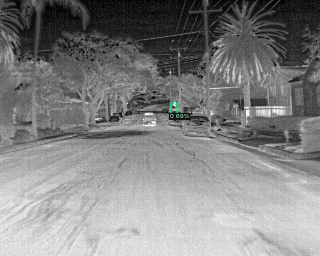

(512, 640, 3)


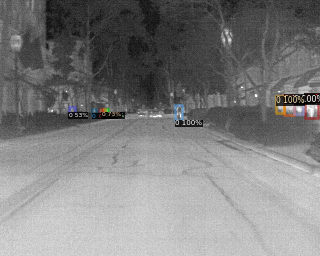

(512, 640, 3)


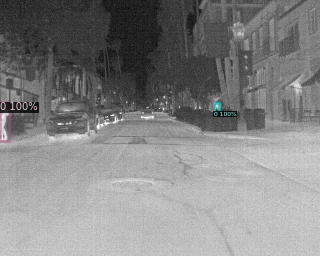

(512, 640, 3)


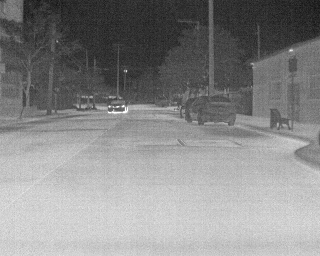

(512, 640, 3)


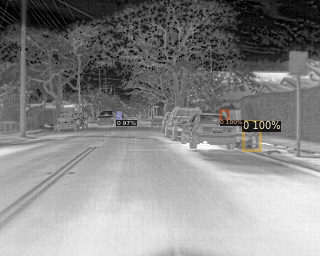

In [ ]:
#see if this shit is wroking aka run instance on test images
from detectron2.utils.visualizer import ColorMode
import numpy as np
dataset_dicts = FLIR("/content/drive/MyDrive/FLIR_THERMAL/val/", "data", "coco.json")
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    print(np.shape(im))
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=FLIR_metadata, 
                   scale=0.5, 
                      # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/R50SRESULTS/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("FLIR_THERMAL_val_data", cfg, False, output_dir="content/output/")
val_loader = build_detection_test_loader(cfg, "FLIR_THERMAL_val_data")
inference_on_dataset(trainer.model, val_loader, evaluator)

[09/15 04:56:49 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

JSONDecodeError: ignored